# Analysis of Gaussian process output

This notebook is used to analyze the Gaussian process output from the file `gp_pipeline.jl`
including the MSD analysis

# Setup and load data

In [5]:
using CSV, DataFrames, Distributions,StatsBase,PythonPlot,Random,CausalityTools,Tables

## Load experimental data

In [15]:
preds = []
params = []
pred_dir = "./../output/output_7-24-24"
files = readdir(pred_dir)
for f in files
    df = CSV.read(pred_dir*"/"*f*"/preds.csv",DataFrame)
    ag(t) = round.(t .- t[1],digits=2)
    df = combine(groupby(df,:position),:time => ag => :age,names(df))
    push!(preds,df)
    push!(params,CSV.read(pred_dir*"/"*f*"/opt_params.csv",DataFrame))
end

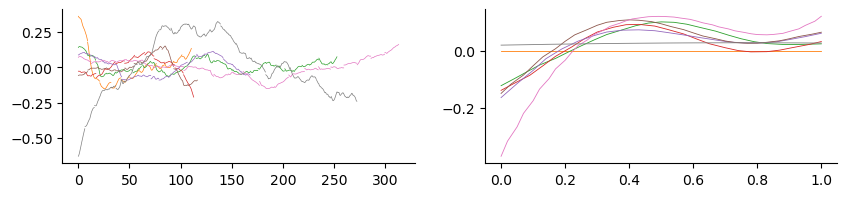

In [16]:
fig,axs = subplots(figsize=(10,2),ncols=2)

ax = axs[0]
for k in 1:length(preds)
    df = preds[k]
    for p in unique(df.position)
        ax.plot(df[df.position .==p,:time],df[df.position .==p,:matern32_flucs],"C"*string(k)*"-",lw=0.5)
    end
end

ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)

ax = axs[1]
for k in 1:length(preds)
    df = preds[k]

    age = df[df.position .==1,:time] .- df[df.position .==1,:time][1]
    age = round.(age ./ age[end],digits=2)
    ax.plot(age,df[df.position .==1,:matern32_cell_x],"C"*string(k)*"-",lw=0.6)
end

ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)


fig

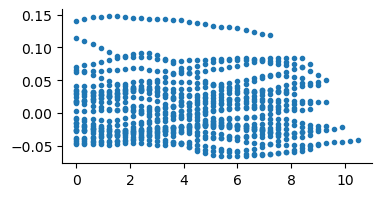

In [17]:
fig,ax = subplots(figsize=(4,2))

df = preds[2]

# for p in unique(df.position)
#     ax.plot(df[df.position .==p,:age],df[df.position .==p,:matern32_flucs_x],".-",lw=0.5)
# end

ax.plot(df.age,df.matern32_flucs,".")
ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)


fig


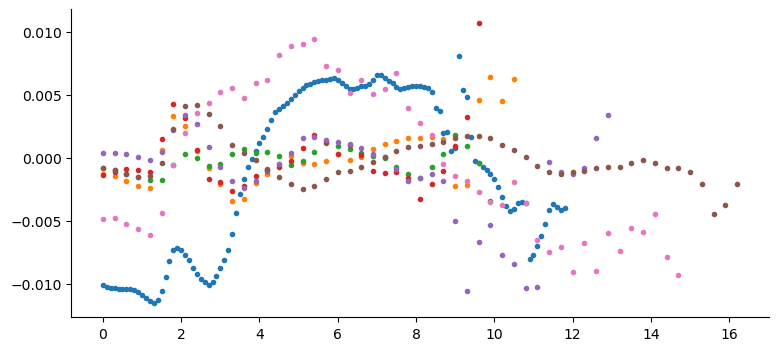

In [39]:
function msd(x)
    var(x .- x[1])
end


fig, ax = subplots(figsize=(9,4))

for df in preds
    df_moments = combine(groupby(df,:age),
        :matern32_flucs => msd => :var_flucs,
        :matern32_flucs_x => msd => :var_flucs_x, 
        :matern32_flucs => mean => :mean_flucs,
        :matern32_flucs_x => mean => :mean_flucs_x);
    ax.plot(df_moments.age,df_moments.mean_flucs_x,".")
end
ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)
#ax.set_ylim([0,0.0005])
fig

## Load simulated data

In [21]:
sim_dir = "./../output/sims/"
files = readdir(sim_dir)
#τ_range = [parse(Int,split(split(f,"_")[end],".")[1]) for f in files]

τ_range = unique([parse(Int,split(split(f,"tau=")[2],"-")[1]) for f in files]);
ϕ_range = unique([parse(Float64,split(split(f,"phi=")[2],".csv")[1]) for f in files]);


In [22]:
sims_raw = [[]]
sims_cells = [[]]
for τ in τ_range
    τ_dfs_raw = []
    τ_dfs_cells = []
    for ϕ in ϕ_range
        println(sim_dir*"/sim_data_tau="*string(τ)*"-phi="*string(ϕ)*".csv")
        df = CSV.read(sim_dir*"/sim_data_tau="*string(τ)*"-phi="*string(ϕ)*".csv",DataFrame)
        push!(τ_dfs_raw,df)
        df_cells = combine(groupby(df,[:position]),:λ=>mean=>:gr,:M=>(x->x[1])=>:M0,:M=>(x->x[end])=>:Mf,:time=>(x->x[end]-x[1])=>:gt)
        df_cells[:,:x] = log.(df_cells.M0 ./ mean(df_cells.M0))
        df_cells[:,:γ] = log.(df_cells.Mf ./ df_cells.M0)
        df_cells[:,:φ] = df_cells.gt .* df_cells.gt
        push!(τ_dfs_cells,df_cells[df_cells.gt .> 0,:])
    end
    push!(sims_raw[end],τ_dfs_raw)
    push!(sims_cells[end],τ_dfs_cells)
end

./../output/sims//sim_data_tau=1-phi=0.0001.csv
./../output/sims//sim_data_tau=1-phi=0.4001.csv
./../output/sims//sim_data_tau=1-phi=0.8001.csv
./../output/sims//sim_data_tau=3-phi=0.0001.csv
./../output/sims//sim_data_tau=3-phi=0.4001.csv
./../output/sims//sim_data_tau=3-phi=0.8001.csv
./../output/sims//sim_data_tau=5-phi=0.0001.csv
./../output/sims//sim_data_tau=5-phi=0.4001.csv
./../output/sims//sim_data_tau=5-phi=0.8001.csv
./../output/sims//sim_data_tau=7-phi=0.0001.csv
./../output/sims//sim_data_tau=7-phi=0.4001.csv
./../output/sims//sim_data_tau=7-phi=0.8001.csv
./../output/sims//sim_data_tau=9-phi=0.0001.csv
./../output/sims//sim_data_tau=9-phi=0.4001.csv
./../output/sims//sim_data_tau=9-phi=0.8001.csv


In [27]:
sims_cells[1][1][1]

Row,position,gr,M0,Mf,gt,x,γ,φ
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,0.059997,40.0,80.0,11.553,-0.0500775,0.693147,133.473
2,1.0,0.0589554,40.0,85.6281,12.9224,-0.0500775,0.761134,166.988
3,2.0,0.0609297,42.814,81.2718,10.528,0.0179092,0.640933,110.838
4,3.0,0.058807,40.6359,81.8847,11.9282,-0.0343051,0.70066,142.281
5,4.0,0.0606652,40.9424,86.7377,12.3816,-0.026792,0.750723,153.304
6,5.0,0.0635514,43.3688,81.4927,10.0065,0.030784,0.630773,100.13
7,6.0,0.0570623,40.7464,64.4452,8.0656,-0.0315903,0.458448,65.054
8,7.0,0.0591033,32.2226,69.2425,12.9516,-0.266289,0.764947,167.745
9,8.0,0.060519,34.6212,65.2424,10.4732,-0.194489,0.633641,109.688


In [29]:
fig, ax = subplots(figsize=(3,3))
for i in 1:length(τ_range)
    vgr = [var(df.gr) for df in sims_cells[3][i]]
    vgt = [var(df.gr) for df in sims_cells[3][i]]
    ax.plot(ϕ_range,vgr,"-",label="τ="*string(τ_range[i]))
    
end
ax.legend()
#ax.set_ylim([0,0.00005])
#ax.set_xlim([0,0.00005])
fig

BoundsError: BoundsError: attempt to access 1-element Vector{Vector{Any}} at index [3]

In [30]:
fig, axs = subplots(figsize=(5,3),ncols=2,nrows=2,sharex=true,sharey=true)

ax = axs[0,0]
ax.plot(sims_raw[1][1].λ[1:1000])
ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)

ax = axs[1,0]
ax.plot(sims_raw[end][1].λ[1:1000])
ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)

ax = axs[0,1]
ax.plot(sims_raw[1][end].λ[1:1000])
ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)

ax = axs[1,1]
ax.plot(sims_raw[end][end].λ[1:1000])
ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)
fig

ErrorException: type Array has no field λ

# MSD

In [31]:
function MSD(x,max_steps)
    n = length(x)
    msd = zeros(max_steps)
    for i in 1:max_steps 
        msd[i] = mean((x[1:end-i] .- x[i+1:end]).^2)
    end
    return msd
end


MSD (generic function with 1 method)

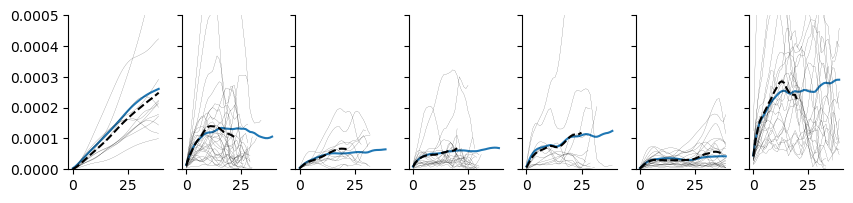

In [32]:
fig,axs = subplots(figsize=(10,2),ncols = length(preds),sharex=true,sharey=true)

for k in 1:length(preds)
    ax = axs[k-1]
    df = preds[k]
    x = df.matern32_flucs_x
    msdx = MSD(x,40)
    ax.plot(msdx)
    mw = []
    for p in unique(df.position)
        xw = df[df.position .==p,:matern32_flucs_x]
        y = MSD(xw,40)
        push!(mw,y)
        ax.plot(y,"k-",lw=0.1)
    end
    mw = hcat(mw...)
    μ = mean(mw,dims=2)
    ax.plot(μ,"k--")
    v = var(mw,dims=2)
   # ax.fill_between(collect(1:length(μ)),μ[1] .- v[1],μ[1])
    ax.set_ylim([0.,0.0005])
    ax.spines["right"].set_visible(false)
    ax.spines["top"].set_visible(false)
end
savefig("./../figures/MSD.pdf")
fig


In [34]:
xw = df[df.position .==2,:matern32_flucs_x]
mw = MSD(xw,20)

xb = df[:,:matern32_flucs_x]
mw = MSD(xw,20)

20-element Vector{Float64}:
 2.5639512322277473e-5
 5.1900141803592524e-5
 7.32025000185889e-5
 0.0001093348330855696
 0.00013614538597330419
 0.00015155523152732354
 0.00017322915574673943
 0.0001860560641707072
 0.0001923206029150677
 0.00022695026622726456
 0.00023228396485530973
 0.00022292209557985847
 0.00022968292232334236
 0.0002194869652541597
 0.00022925168497567265
 0.0002603045925166169
 0.0002829160451192311
 0.0002479076049253556
 0.00025190918175955416
 0.0002358678398122659

In [37]:
xw


31-element Vector{Float64}:
 -0.0012453760227844769
  0.0010734521603471979
  0.0035882104760243034
  0.0063112229623896515
  0.009255501435955252
  0.012202983418514498
  0.012590147769959441
  0.01933418997390022
  0.018563122405646042
  0.014266394486821016
  ⋮
  0.018724669913898914
  0.012594107788697902
  0.01591034969823123
  0.018317135793776394
  0.014164693539965233
  0.0023019152893298802
  0.005499699414958639
  0.003884757558385449
 -0.004146376807577744

In [ ]:

fig,ax = subplots(figsize=(10,2))
ax.imshow((x .- x').^2)
fig

# Causality

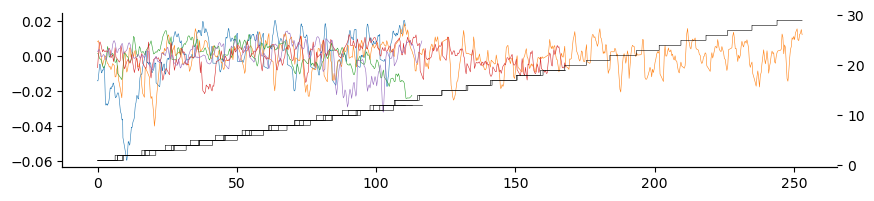

In [58]:
fig,ax = subplots(figsize=(10,2))
ax2 =ax.twinx()
for k in 1:5
    df = preds[k]
    ax.plot(df.time,df.matern32_flucs_x,"-",lw=0.4)
    #ax.plot(df.time,df.matern32_cell_x,"-")

    ax2.step(df.time,df.position,"k-",lw=0.4)
end

ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)
ax2.spines["right"].set_visible(false)
ax2.spines["top"].set_visible(false)
fig